# Looking at videos with no detected faces

In [47]:
%reload_ext autoreload
%autoreload 2

In [48]:
#export
from fastai.vision import *
from IPython.display import HTML
import cv2
import pandas as pd
from facenet_pytorch import MTCNN

from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_01b import *

### Data

In [4]:
SOURCE = Path('../data/train_sample_videos/')

In [5]:
annots = pd.read_csv('annots_noface.csv')

In [6]:
annots.head()

,fname,label,split,original
0,adhsbajydo.mp4,FAKE,train,fysyrqfguw.mp4
1,agrmhtjdlk.mp4,REAL,train,NaN
2,andaxzscny.mp4,FAKE,train,fysyrqfguw.mp4
3,aorjvbyxhw.mp4,FAKE,train,bulkxhhknf.mp4
4,atvmxvwyns.mp4,REAL,train,NaN


In [6]:
fnames = [SOURCE/o for o in annots.fname]
labels = [f'{o.fname} {o.label}' for i, o in annots.iterrows()]

In [7]:
HTML(html_vids(fnames, titles=labels))

### Darkish videos

Many of these videos have poor lighting.  Let's consider these in this section.

In [201]:
fn = 'atvmxvwyns.mp4'

In [202]:
vcap = cv2.VideoCapture(str(SOURCE/fn))

In [203]:
success, frame = vcap.read()

In [204]:
success

True

In [205]:
vcap.release()

In [206]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#frame = PIL.Image.fromarray(frame)

In [207]:
pilimg = PIL.Image.fromarray(frame)
img = tensor(frame).permute(2, 0, 1)

Scale up all values increases the brightness of the image.  (Don't know if there is a better way to increase brightness.)

In [208]:
img_brighter = (2 * img.float()).clamp_max(255).clamp_min(0).type(torch.uint8)

In [209]:
pilimg_brighter = PIL.Image.fromarray(img_brighter.permute(1, 2, 0).numpy())

tensor([44.7277, 32.8818, 23.9042])

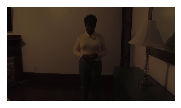

In [210]:
Image(img).show(); img.float().mean(dim=[1, 2])

tensor([89.4554, 65.7637, 47.8085])

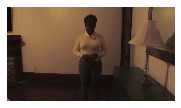

In [211]:
Image(img_brighter).show(); img_brighter.float().mean(dim=[1, 2])

In [212]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [213]:
detector = MTCNN(device=device, post_process=False)

In [214]:
face = detector(pilimg)

In [215]:
face is None

True

In [216]:
face_brighter = detector(pilimg_brighter)

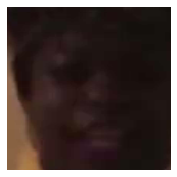

In [219]:
Image(face_brighter.type(torch.uint8)).show()

By increasing the brightness, a face from the first frame of the following videos is detected:

* esyhwdfnxs.mp4 2x  
* eoewqcpbgt.mp4 2x
* atvmxvwyns.mp4 2x

'2x' indicates that the image array was multiplied by 2.  Multiplying by 1.5 didn't work, at least not for the first video listed here.

### Video with two people

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

In [9]:
fn = 'agrmhtjdlk.mp4'

Let's first reproduce the problem: that no face is detected using `DetectionPipeline`.

#### Using `get_first_face`

There was a bug with a previous version of this function.  After this was fixed, it now detects face. 

This will only return the face of the woman, because it's the first face to appear in the video.

In [10]:
face = get_first_face(detector, SOURCE/fn)

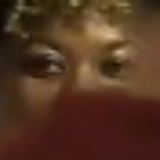

In [11]:
Image(face[1].type(torch.uint8))

#### Using `DetectionPipeline`

In [13]:
detectpipe = DetectionPipeline(detector, resize=.5)

In [14]:
faces = detectpipe(str(SOURCE/fn))

In this image below, the man's back is to the viewer, he's partially blocking the woman's face.  In this frame, the woman's face is the only face.

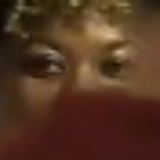

In [23]:
Image(faces[5].type(torch.uint8))

In the video, the man turns around and reveals his face, making his the other face in the frame below.  In this case, the detector returns the man's face instead of the woman's.

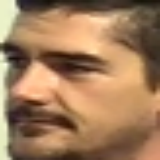

In [16]:
Image(faces[178].type(torch.uint8))

#### Using cv2 straight up 

In [68]:
vcap = cv2.VideoCapture(str(SOURCE/fn))

In [69]:
vlen = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))

Let's look at a frame with 2 faces

In [70]:
idxs = [203]

In [71]:
frames = []
for i in range(vlen):
    success, frame = vcap.read()
    if i in idxs:
        if success: frames.append(frame)
        else: frames.append(None)
    if i == idxs[-1]: break

In [72]:
vcap.release()

In [73]:
len(frames)

1

In [74]:
frames = [cv2.cvtColor(o, cv2.COLOR_BGR2RGB) for o in frames]

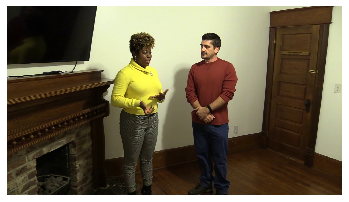

In [75]:
plt.imshow(frames[0]); plt.axis('off');

In [76]:
img = frames[0]
pilimg = PIL.Image.fromarray(img)

Resize the image by 0.5, the woman's face is detected.

In [77]:
sz_smll = tuple(int(.5 * o) for o in pilimg.size)
sz_smll

(960, 540)

In [78]:
face = detector(pilimg.resize(sz_smll))

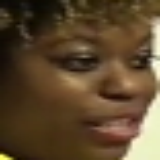

In [79]:
Image(face.type(torch.uint8))

Using frame with original size, the man's face is detected.

In [80]:
face = detector(pilimg)

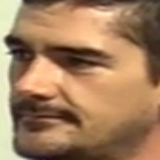

In [81]:
Image(face.type(torch.uint8))

#### Mini-summary
It's hard to tell which face the detector will pick out of the two.  In some frames, it picks out the woman's, in some other it picks out the man's.

### The very-blurry-face one

In [7]:
fn = 'aorjvbyxhw.mp4'

In [12]:
HTML(html_vid(SOURCE/fn))

In [49]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

`get_first_face` now returns a face from the second frame, which means the bug before prevented a face to be detected in this video.

In [50]:
face = get_first_face(detector, SOURCE/fn)

300
0
1


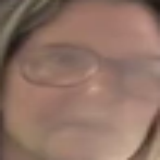

In [51]:
Image(face[1].type(torch.uint8))

# - fin